In [4]:
import mne
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import spectrogram, get_window
from IPython.display import Audio

# Función para graficar el espectrograma
def plot_spectrogram(signal, sample_rate, overlapping = 0., window_type='hann', window_size=256):
    """
    Genera y grafica el espectrograma de una señal.

    Parámetros:
    - signal: la señal de audio
    - window_type: el tipo de ventana a usar (string, por ejemplo 'hann', 'hamming', etc.)
    - window_size: tamaño de la ventana (entero)
    - overlapping: porcentaje de solapamiento (valor entre 0 y 1)
    - fs: frecuencia de muestreo de la señal
    """
    # Crear la ventana
    window = get_window(window_type, window_size)

    # Calcular el paso de la ventana en función del solapamiento
    noverlap = int(overlapping * window_size)

    # Calcular el espectrograma usando scipy.signal.spectrogram
    f, t, Sxx = spectrogram(signal, fs=sample_rate, window=window,
                            nperseg=window_size, noverlap=noverlap)


    # Graficar el espectrograma
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.title('Espectrograma')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.colorbar(label='Amplitud [dB]')
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(30000,)


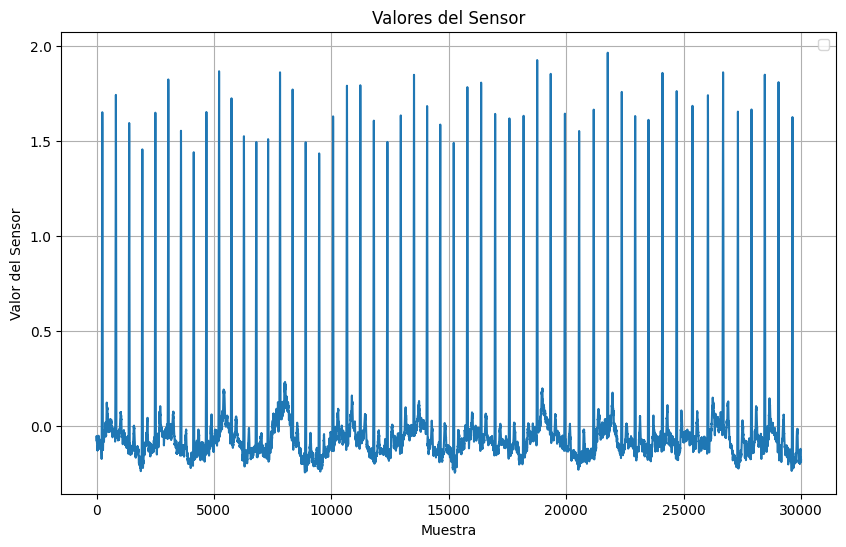

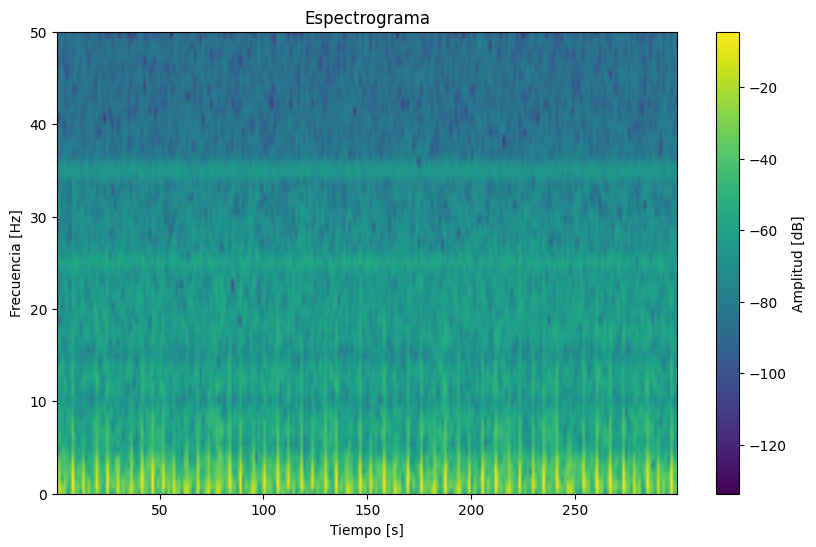

In [31]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Abre el archivo .dat en modo binario
record_name = 'NIFAECG/NR_02'

# Cargar el archivo .dat y su metainformación
record = wfdb.rdrecord(record_name)

# Acceder a los datos de la señal
signals = record.p_signal[30000:60000,0]
print(signals.shape)

# Graficar los valores del sensor
plt.figure(figsize=(10, 6))
plt.plot(signals)
plt.xlabel('Muestra')
plt.ylabel('Valor del Sensor')
plt.title('Valores del Sensor')
plt.legend()
plt.grid(True)
plt.show()

plot_spectrogram(signals, 100, window_type='hann', window_size=128, overlapping=0.)
